In [4]:
# An imperfect mirror with an imperfect KB
# This script is created by Jacek Krzywinski and modified by Juncheng E to read files in DEMO paths.

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys

wpg_path = '/gpfs/exfel/data/user/juncheng/WPG/'
sys.path.insert(0,wpg_path)
sys.path.insert(0,'/gpfs/exfel/data/user/juncheng/lume-simex-demo-1/models/wpg')

import time
import copy
import numpy as np
import pylab as plt
from h5py import File


import wpg

#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL,SRWLOptMirEl
from wpg.srwlib import SRWLWfr

#import openpmd reader
from pmd_wavefront.interfaces.srw import srw_wfr_from_openpmd_wavefront

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh
from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy,build_gauss_wavefront

from wpg.wpg_uti_wf import calculate_fwhm, averaged_intensity, look_at_q_space, plot_wf,plot_intensity_qmap

In [7]:
plt.ion()

In [8]:
#Plotting
def plot_1d(profile, title_fig, title_x, title_y):
    plt.plot(profile[0], profile[1])
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)
    plt.grid(True)


def plot_2d(amap, xmin, xmax, ymin, ymax, title_fig, title_x, title_y):
    plt.imshow(amap, extent=(ymin, ymax, xmin, xmax))
    plt.colorbar()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)

def _resample(wf, axis, data, x0, x1):
    if axis.lower()=='x':
        y = data[int(data.shape[0]/2),:]
        x = np.linspace(wf.params.Mesh.xMin, wf.params.Mesh.xMax, y.shape[0])
    elif axis.lower()=='y':
        y = data[:,int(data.shape[1]/2)]
        x = np.linspace(wf.params.Mesh.yMin, wf.params.Mesh.yMax, y.shape[0])
    else:
        raise ValueError(
            'Wrong axis {}, should be "x" or "y"'.format(axis))

    if not x0 is None:
        xmin = x0
    else:
        xmin = x[0]

    if not x1 is None:
        xmax = x1
    else:
        xmax = x[-1]

    x1 = np.linspace(xmin,xmax,len(y))
    y1 = np.interp(x1, x,y)
    return x1, y1

def intensity_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    elif polarization.lower() == 't' or polarization.lower() == 'total':
        pol = 'total'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical"'+
            ' or "h" or "horizontal" or "t" or "total"'.format(polarization))

    data = wf.get_intensity(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

def phase_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical" or "h" or "horizontal"'.format(polarization))

    data = wf.get_phase(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

#calculate source size from photon energy and FWHM angular divergence
def calculate_source_fwhm(ekev, theta_fwhm):
    wl = 12.39e-10/ekev
    k = 2 * np.sqrt(2*np.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*np.pi*theta_sigma)
    return sigma0*k

#calculate angular divergence using formula from CDR2011
def calculate_theta_fwhm_cdr(ekev,qnC):
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

#define optical path difference (OPD) from mirror profile, i.e.
#fill the struct opTrErMirr
#input:
#    mdatafile: an ascii file with mirror profile data
#    ncol:      number of columns in the file
#    delim:     delimiter between numbers in an row, can be space (' '), tab '\t', etc
#    Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
#    theta:     incidence angle
#    scale:     scaling factor for the mirror profile
def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    heightProfData = np.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    plt.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)') #@todo add the func def in on top of example

def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator

    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=np.cos(theta0), _nvy=0, _nvz=-np.sin(theta0), _tvx=-np.sin(theta0), _tvy=0,
                             _x=0, _y=0, _treat_in_out=1)
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=0, _nvy=np.cos(theta0), _nvz=-np.sin(theta0), _tvx=0, _tvy=-np.sin(theta0),
                             _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

## Read openPMD wavefront source

range_xy 0.0012666666666666666 0.0012666666666666666 m
Curvature radius 0.0 0.0
Curvature radius errors 0.0 0.0


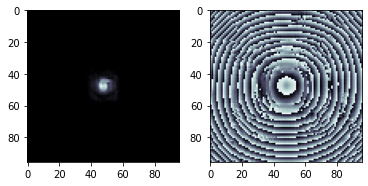

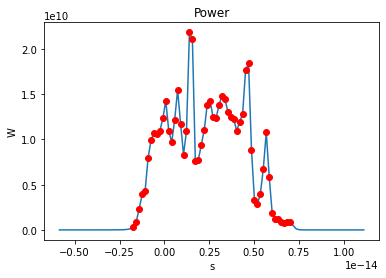

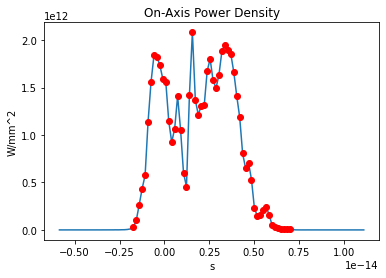

number of meaningful slices: 54
Pulse energy 8.3e-05 J
R-space
(96,) (96,)
FWHM in x = 7.917e-05 m.
FWHM in y = 7.917e-05 m.


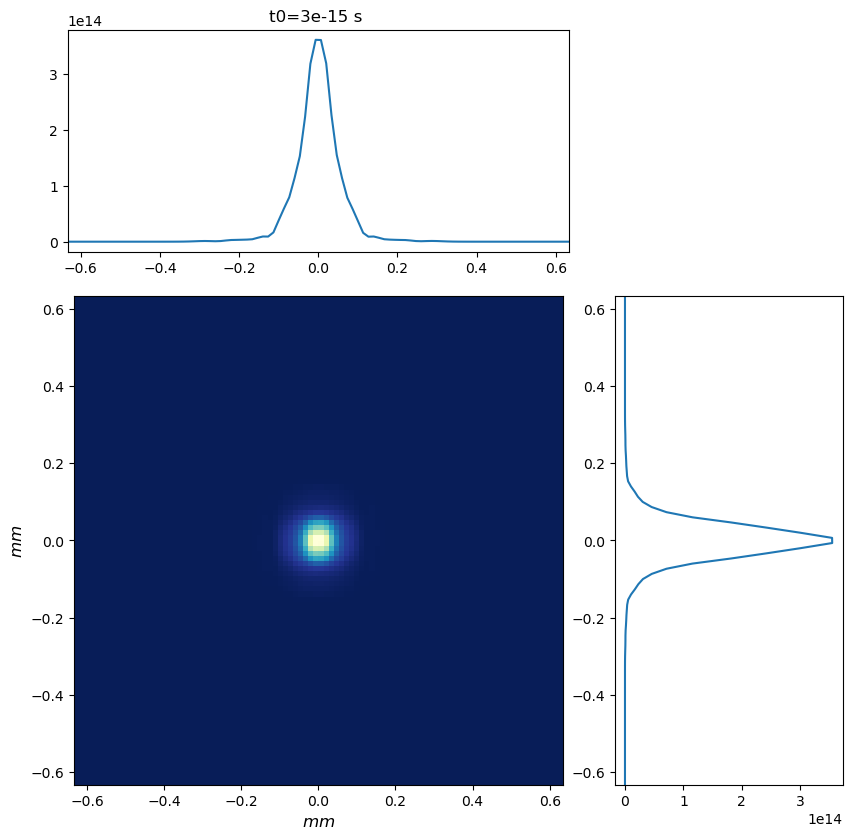

Q-space
{'fwhm_x': 3.1151337675638065e-06, 'fwhm_y': 3.1151337675638065e-06}
Q-space
(96,) (96,)


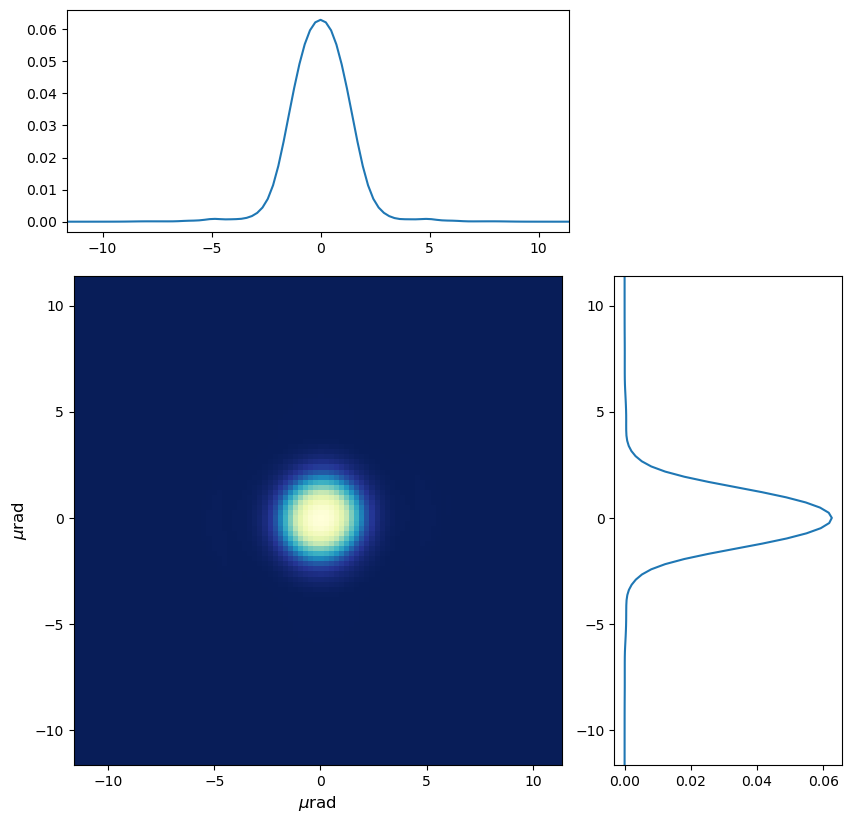

In [27]:
strInputDataFolder = '../wpg-samples/data_common'  # input data sub-folder name
strOutputDataFolder = '../'  # output data sub-folder name

# fname0 = 'wpg_helper/HXR_4keV_8fs_0.6'
fname0 = 'wpg_helper/HXR_4keV_8fs_0.6'
# fname0 = 'wpg_helper/trimedGenesisHRX_4keV_test'
ifname = os.path.join(strOutputDataFolder,fname0+'.h5')

#init WPG Wavefront helper class
mwf = Wavefront()
mwf.load_hdf5(ifname)

# mwf = Wavefront(build_gauss_wavefront(512, 512, 20, 4.000,
#                                       xMin = -500e-06, xMax = 500e-06, 
#                                       yMin = -500e-06 , yMax = 500e-06 , 
#                                       tau = 1e-15, sigX = 1e-05, 
#                                       sigY = 1e-05, d2waist = 10, pulseEn = 1e6))

mesh = mwf.params.Mesh
range_x = mesh.xMax-mesh.xMin
range_y = mesh.yMax-mesh.yMin
range_xy = range_x
print ('range_xy',range_x,range_y,'m')
print ('Curvature radius',mwf.params.Rx,mwf.params.Ry)
print ('Curvature radius errors',mwf.params.dRx ,mwf.params.dRy)

#draw wavefront with common functions
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

plot_wf(mwf)
plot_intensity_qmap(mwf)

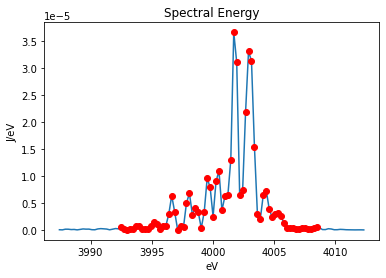

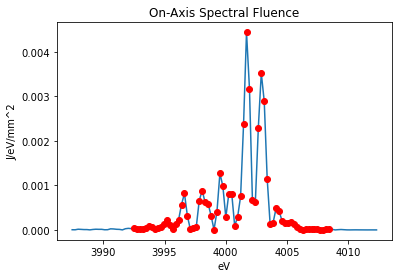

number of meaningful slices: 67
R-space
(96,) (96,)
FWHM in x = 7.917e-05 m.
FWHM in y = 7.917e-05 m.


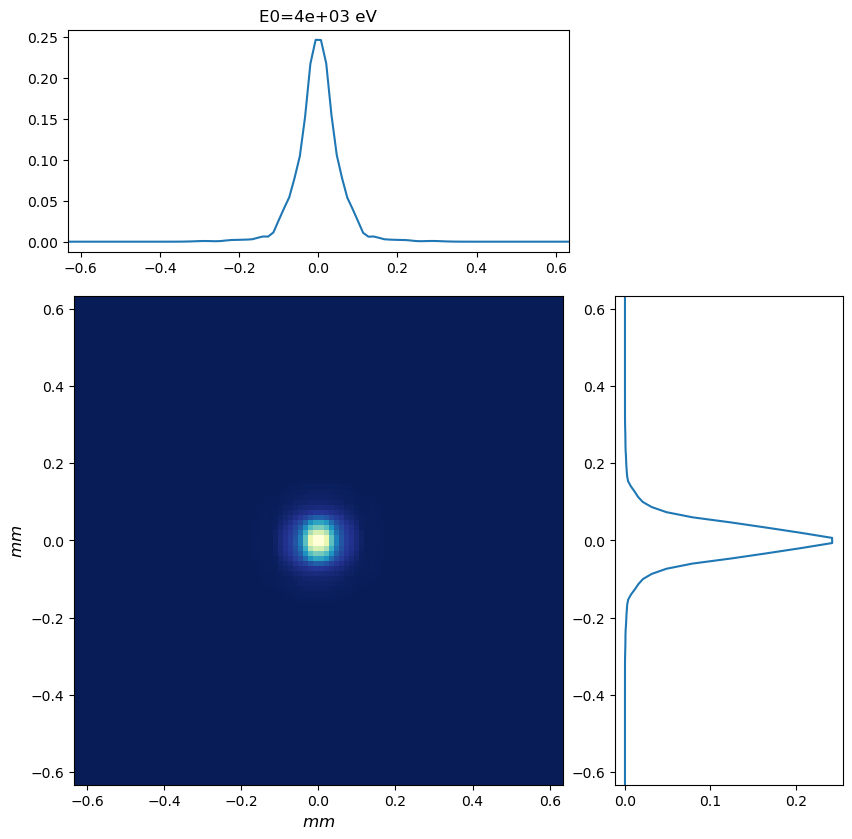

In [28]:
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
plot_wf(mwf)

## Modify curvature

In [29]:
mwf.params.Rx = 15
mwf.params.Ry = 15
mwf.params.dRx = 0.01
mwf.params.dRy = 0.01

## Start propagation

*****Source
FWHMx [mm]: 0.0666666666666667
FWHMy [mm]: 0.0933333333333334
Coordinates of center, [mm]: 0.006666666666666648 0.006666666666666648
stepX, stepY [um]: 13.333333333333334 13.333333333333334 

Total power (integrated over full range): 2.9969e-32 [GW]
Peak power calculated using FWHM:         1.89991e-32 [GW]
Max irradiance: 2.68376e-30 [GW/mm^2]
R-space
FWHMx [um], FWHMy [um]: 66.6666666666667 93.3333333333334
Curvature radius 15.0 15.0
Curvature radius errors 0.01 0.01


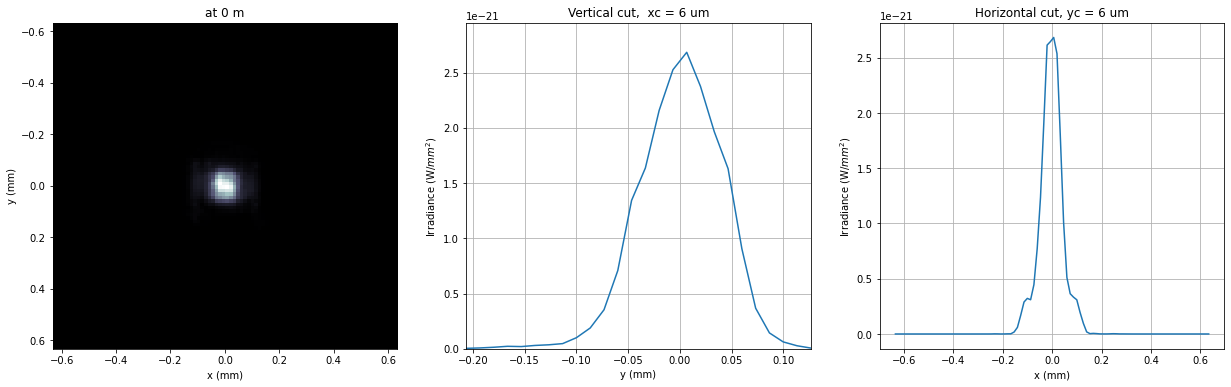

In [30]:
print('*****Source')
bOnePlot= True
isHlog = False
isVlog = False
bSaved = True
plot_wfront(mwf, 'at 0 m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)

#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)
print ('Curvature radius',mwf.params.Rx,mwf.params.Ry)
print ('Curvature radius errors',mwf.params.dRx ,mwf.params.dRy)

## Mirror parameters

In [31]:
thetaOM = 7.e-3    # angle of incidence for the offset mirror
d2m1 = 90.66       # distance to the first offset mirror
d2hkb = 119.75      #distance to the first HFM KB
thetaKB = 7.e-3     # angle of incidence for the KB mirrorsr
dhkb_foc = 3.5     # nominal focal length for HFM KB
dvkb_foc = 2.5     # nominal focal length for VFM KB
dhkb_vkb = dhkb_foc - dvkb_foc       # distance between centers of HFM and VFM
lengthOM=0.8        #length of the offset mirror
lengthKB=0.8        # length of the KB mirror

z1 = d2m1

In [32]:
print('*****Defining optical beamline from first offset mirror (M1) to exp hall')

z2 = d2hkb - d2m1

DriftM1_KB = SRWLOptD(z2) #Drift from first offset mirror (M1) to exp hall
horApM1 = lengthOM*thetaOM
opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
horApKB = lengthKB * thetaKB # Aperture of the KB system, CA 0.8 m
opApKB = SRWLOptA('r', 'a', horApKB, horApKB)  # clear aperture of the Offset Mirror(s)
opLens = SRWLOptL()

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftM1_KB =    [ 0,  0, 1.0,  1,  0, 3.0, 1.8, 3.0, 1.8,  0,  0,   0]
ppApKB =          [ 0,  0, 1.0,  0,  0, 0.2, 2.0, 0.2, 2.0,  0,  0,   0]
ppHKB =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErHKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_HKB_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_KB =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppVKB =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErVKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_foc =     [ 0,  0, 1.0,  1,  0, 2.0, 0.5, 2.0, 0.5,  0,  0,   0]
#ppFin  =          [ 0,  0, 1.0,  0,  0, 0.05,5.0, 0.05,5.0,  0,  0,   0]
ppFin =           [ 0,  0, 1.0,  0,  1, .01, 20.0, .01, 20.0,  0,  0,   0]

*****Defining optical beamline from first offset mirror (M1) to exp hall


*****Ideal mirror
*****setting-up optical elements, beamline: bl0
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.0012666666666666666
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 3.0, 1.8, 3.0, 1.8, 0, 0, 0]
	L = 29.090000000000003
	treat = 0
	

frequency
propagation lasted: 0.1 min


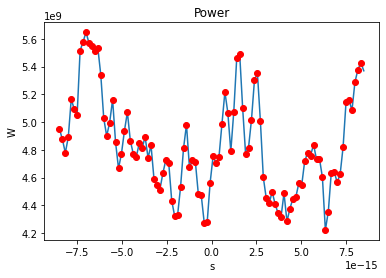

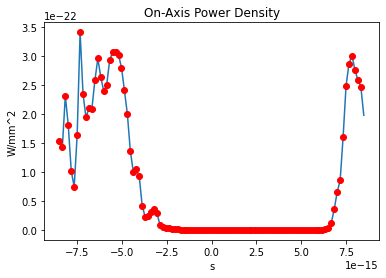

number of meaningful slices: 103
Pulse energy 8.2e-05 J
R-space
(520,) (520,)
FWHM in x = 6.219e+12 m.
FWHM in y = 5.608e+12 m.


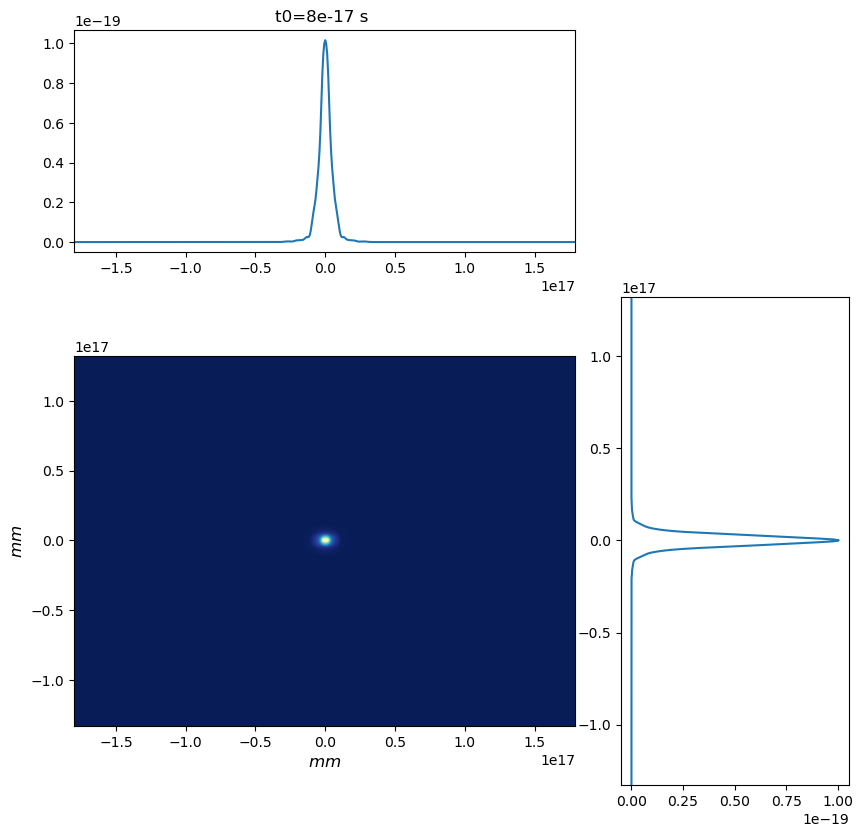

In [33]:
print('*****Ideal mirror')
optBL0 = SRWLOptC([opApM1,  DriftM1_KB],
                  [ppM1,ppDriftM1_KB])
bSaved = False
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:', strBL)
bl=Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

startTime = time.time()

mwf = Wavefront()
mwf.load_hdf5(ifname)
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
print (mwf.params.wDomain)

bl.propagate(mwf)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

srwl.SetRepresElecField(mwf._srwl_wf, 't')
plot_wf(mwf)

*****HOM1 data for BL1 beamline 
horApM1 = 0.005600000000000001
verApM1 = 0.0012666666666666666


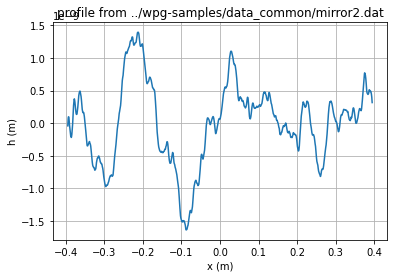

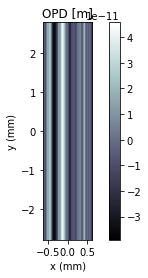

In [22]:
print('*****HOM1 data for BL1 beamline ')
scale = 2     #5 mirror profile scaling factor
opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
#defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')
print ('horApM1 =',horApM1)
print ('verApM1 =',range_xy)
optBL1 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB],
                    [ppM1,ppTrErM1,ppDriftM1_KB])

*****Imperfect HOM mirror, at KB aperture
*****setting-up optical elements, beamline: bl1
save hdf5: ../wpg_helper/HXR_4keV_8fs_0.6_bl1.h5
frequency
propagation lasted: 0.1 min


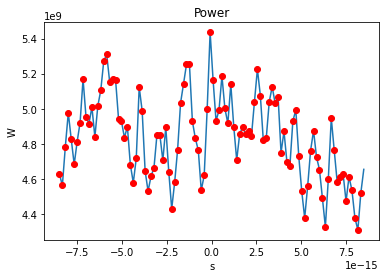

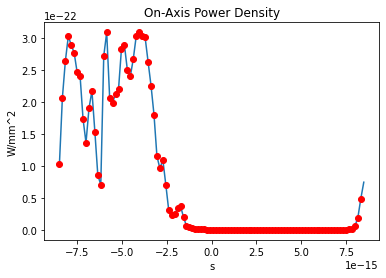

number of meaningful slices: 103
Pulse energy 8.2e-05 J
R-space
(520,) (520,)
FWHM in x = 6.219e+12 m.
FWHM in y = 5.608e+12 m.


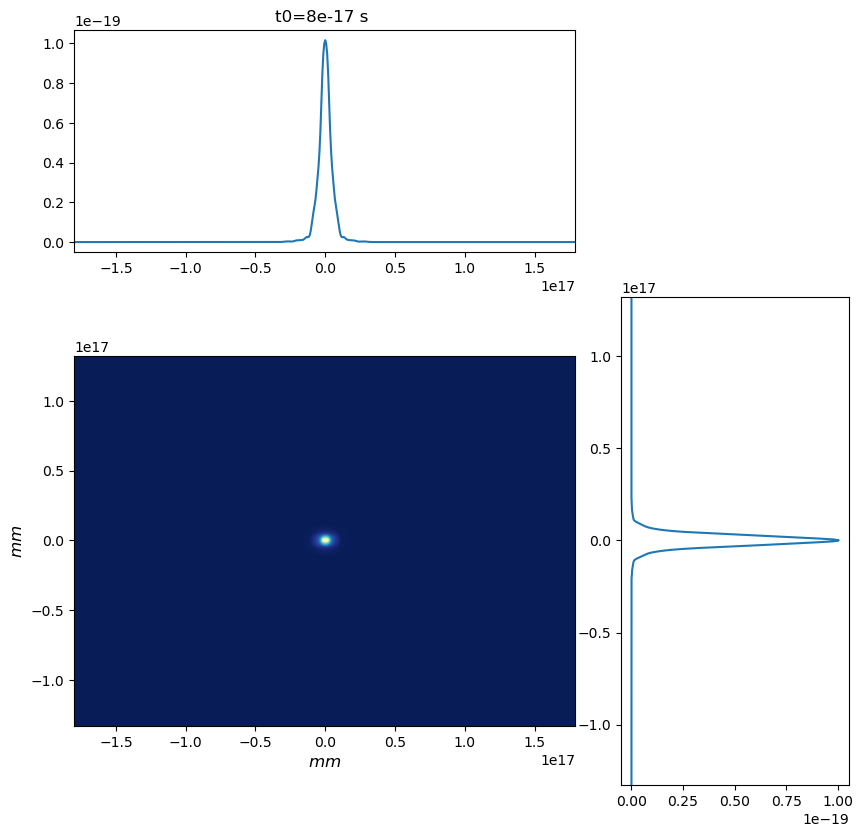

In [23]:
print('*****Imperfect HOM mirror, at KB aperture')
bPlotted = False
isHlog = True
isVlog = False
bSaved = True
optBL = optBL1
strBL = 'bl1'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:', strBL)
bl=Beamline(optBL)
# print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = Wavefront()
mwf.load_hdf5(ifname)
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
print (mwf.params.wDomain)

bl.propagate(mwf)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

srwl.SetRepresElecField(mwf._srwl_wf, 't')
plot_wf(mwf)